# Week 2.5: Real world Dask
Author: Juana Karina Diaz Barba
  

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import yaml

# client = Client()
# client

In [2]:
def get_config():
    '''Setting the config file'''
    with open('config_prog2.yaml', 'r') as stream:
        config = yaml.safe_load(stream)
        return config

config = get_config()
bacilli_path = (config['bacilli'])

Creating a pandas dataframe  with a small subset of the data, to see how the data looks like 

In [3]:
df = pd.read_csv(bacilli_path, delimiter='\t', header= None, nrows= 10, 
                    names = ["protein_id", "protein_md5", "protein_length", 
                           "analysis", "signature_id", "signature_description", 
                           "Start location", "Stop location", "score", "status", 
                           "date", "interpro_id", "interpro_desc", "go_terms", 
                           "pathway_terms"], dtype={'score': 'object'})
print(df.head(3))
datatypes = df.dtypes.to_list()
print(datatypes)

                   protein_id                       protein_md5  \
0  gi|29898682|gb|AAP11954.1|  92d1264e347e149248231cb9b649388c   
1  gi|29898682|gb|AAP11954.1|  92d1264e347e149248231cb9b649388c   
2  gi|29898682|gb|AAP11954.1|  92d1264e347e149248231cb9b649388c   

   protein_length         analysis signature_id  \
0             547          TIGRFAM    TIGR03882   
1             547          TIGRFAM    TIGR03604   
2             547  ProSiteProfiles      PS51664   

                               signature_description  Start location  \
0  cyclo_dehyd_2: bacteriocin biosynthesis cyclod...               2   
1  TOMM_cyclo_SagD: thiazole/oxazole-forming pept...             161   
2                               YcaO domain profile.             159   

   Stop location      score status        date interpro_id  \
0            131    1.6E-21      T  25-04-2022   IPR022291   
1            547        0.0      T  25-04-2022   IPR027624   
2            547  75.396477      T  25-04-2022   IP

The data types are correct. But to avoid problems we are going to set dtype={'score': 'object'} to avoid future errors.   
  
The correct column names were obtained from the data description: 
https://interproscan-docs.readthedocs.io/en/latest/OutputFormats.html#example-output 

In [4]:
# Creating a dask dataframe with different partitions

ddf = dd.read_csv(bacilli_path, delimiter='\t',  header=None, 
                  names = ["protein_id", "protein_md5", "protein_length", 
                           "analysis", "signature_id", "signature_description", 
                           "Start location", "Stop location", "score", "status", 
                           "date", "interpro_id", "interpro_desc", "go_terms", 
                           "pathway_terms"], dtype={'score': 'object'})
ddf

,protein_id,protein_md5,protein_length,analysis,signature_id,signature_description,Start location,Stop location,score,status,date,interpro_id,interpro_desc,go_terms,pathway_terms
npartitions=174,,,,,,,,,,,,,,,
,object,object,int64,object,object,object,int64,int64,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
ddf.dask

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fbdefd8d750>
 0. read-csv-eeb631b3b03e0b473aa5c63b731af4e8

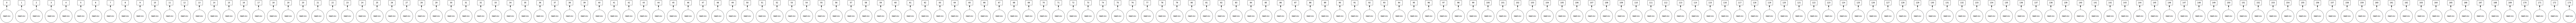

In [6]:
ddf.visualize()

### 1. How many distinct protein annotations are found in the dataset?  
I.e. how many distinc InterPRO numbers are there?

In [7]:
# I use '.compute(num_workers=16)' to distribute the computation across these 
# workers to parallelize the task and speed up the processing of your dataset.
interpro_count = ddf['interpro_id'].nunique().compute(num_workers=16)
print("Number of distinct InterPro numbers:", interpro_count)


Number of distinct InterPro numbers: 9704


### 2. How many annotations does a protein have on average?

In [ ]:
# Group by 'protein_id' and calculate how many 'interpro_id' are in each 'protein_id group'
interpro_per_protein = ddf.groupby('protein_id')['interpro_id'].count()

# Mean 'interpro_id' per protein
mean_annotation_per_protein = interpro_per_protein.mean().compute(num_workers=16)

print("Average number of annotations per protein:", mean_annotation_per_protein)

Average number of annotations per protein: 11.490524386574391


### 3. What is the most common GO Term found?

In [ ]:
# Filter out rows where go_terms is equal to '-'
ddf_filtered = ddf[ddf['go_terms'] != '-']

# Obtain the value counts per go term and select the one with the max number
go_term = ddf_filtered['go_terms'].value_counts().idxmax().compute(num_workers=16)
# Get the max count of the go_terms
go_count = ddf_filtered['go_terms'].value_counts().max().compute(num_workers=16)
print(f'Most common Go term: {go_term} with {go_count} counts')

Most common Go term: GO:0003700|GO:0006355 with 33500 counts


### 4. What is the average size of an InterPRO feature found in the dataset?

In [25]:
# Obtain the feature size by resting the stop and start location
feature_size = ddf['Stop location']- ddf['Start location']
# Obtain mean of size
feature_mean = feature_size.mean().compute(num_workers=16)
print(f'Mean feature size: {feature_mean}')


Mean feature size: 131.73178916966685


### 5. What is the top 10 most common InterPRO features?

In [24]:
# Filter out rows where interpro_id is equal to '-'
ddf_filtered = ddf[ddf['interpro_id'] != '-']
# Group by 'interpro_id' and count how many values per id are
interpro_id_counts = ddf_filtered.groupby('interpro_id')['interpro_id'].count().compute(num_workers=16)
# Get only the 10 largest entries
top_ten = interpro_id_counts.nlargest(10)
print('Top ten most common interpro features')
print(top_ten)

Top ten most common interpro features
interpro_id
IPR027417    46834
IPR002347    18077
IPR003439    16944
IPR036388    16291
IPR036259    12602
IPR003593    11521
IPR036390    11304
IPR036291    10716
IPR000515    10613
IPR001789    10471
Name: interpro_id, dtype: int64


### 6.  If you select InterPRO features that are almost the same size (within 90-100%) as the protein itself, what is the top10 then?

In [10]:
# Set index to 'protein_id'
ddf_with_index = ddf.set_index('protein_id')

# Get the maximum protein length per protein_id
protein_length = ddf_with_index.groupby('protein_id')['protein_length'].max().compute()

# Select the entries wich protein lenght is within 90-100%
similar_size = ddf_with_index[(ddf_with_index['protein_length'] >= protein_length * 0.9) & 
                                       (ddf_with_index['protein_length'] <= protein_length * 1.0)]

# Reset index
similar_size = similar_size.reset_index()


ignoring exception in ensure_cleanup_on_exception
Traceback (most recent call last):
  File "/commons/conda/dsls/lib/python3.10/site-packages/dask/dataframe/shuffle.py", line 953, in ensure_cleanup_on_exception
    yield
  File "/commons/conda/dsls/lib/python3.10/site-packages/dask/dataframe/shuffle.py", line 968, in shuffle_group_3
    p.append(d, fsync=True)
  File "/commons/conda/dsls/lib/python3.10/site-packages/partd/encode.py", line 25, in append
    self.partd.append(data, **kwargs)
  File "/commons/conda/dsls/lib/python3.10/site-packages/partd/buffer.py", line 45, in append
    self.flush(keys)
  File "/commons/conda/dsls/lib/python3.10/site-packages/partd/buffer.py", line 99, in flush
    self.slow.append(dict(zip(keys, self.fast.get(keys))))
  File "/commons/conda/dsls/lib/python3.10/site-packages/partd/file.py", line 44, in append
    f.write(v)
OSError: [Errno 28] No space left on device

During handling of the above exception, another exception occurred:

Traceback (most r

OSError: [Errno 28] No space left on device

There was some problem of memory and the command could not finish (error: No space left on the device). But after hetting the entries wich protein lenght is within 90-100% the next stepes are shown in the following cell

In [ ]:
# Group by interpro_id and count how many entries are 
interpro_id_counts = similar_size.groupby('interpro_id')['interpro_id'].count().compute(num_workers=16)
# Get only the 10 largest entries
print("Interpro Features Counts:")
top_ten_inter = interpro_id_counts.nlargest(10)
top_ten_inter

### 7. If you look at those features which also have textual annotaion, what is the top 10 most common word found in that annotaion?

In [15]:
# Get a subset of the daskdatafram ddf with the top ten features
ddf_subset = ddf[ddf['interpro_id'].isin(top_ten.index)]

# converts the text to lowercase, split each text element into a list of words and 
# convert every list element into a separate row
annotation_words = ddf_subset['interpro_desc'].str.lower().str.split().explode()

# Get the counts per word and only select the 10 largest
top_ten_common_words = annotation_words.value_counts().nlargest(10).compute(num_workers=16)
    
print("Top ten common annotations")
print(top_ten_common_words)

Top ten common annotations
domain          87860
superfamily     50913
nucleoside      46834
triphosphate    46834
p-loop          46834
containing      46834
hydrolase       46834
winged          27595
dna-binding     27595
abc             27557
Name: interpro_desc, dtype: int64


### 8. And the top 10 least common?

In [14]:
# Get the counts per word and only select the 10 largest
top_ten_least_common_words = annotation_words.value_counts().nsmallest(10).compute(num_workers=16)
    
print("Top ten least common annotations")
print(top_ten_least_common_words)

Top ten least common annotations
transduction      10471
signal            10471
regulator,        10471
receiver          10471
response          10471
transmembrane     10613
type              10613
1,                10613
meti-like         10613
nad(p)-binding    10716
Name: interpro_desc, dtype: int64


### 9. Combining your answers for Q6 and Q7, what are the 10 most commons words found for the largest InterPRO features?

In [16]:
common_words_largest_interpro = annotation_words[annotation_words.index.isin(top_ten.index)]
top_10_common_words_largest_interpro = common_words_largest_interpro.value_counts().nlargest(10).compute(num_workers=16)


In [22]:
print(f'Ten most commons words in the largest Interpro features: {top_10_common_words_largest_interpro}')


Ten most commons words in the largest Interpro features: Series([], Name: interpro_desc, dtype: int64)


### 10. What is the coefficient of correlation (R^2) between the size of the protein and the number of features found?

In [19]:
correlation_coefficient = ddf.groupby('protein_id').agg(
                                                    {'protein_length': 'max', 
                                                    'interpro_id': 'count'}).corr().compute(num_workers=16)
correlation = correlation_coefficient.iloc[0, 1]



In [23]:
print(f'Coefficient of correlation: {correlation}')

Coefficient of correlation: 0.6387083370364052


In [ ]:
# Close the Dask client
#client.close()